<a href="https://colab.research.google.com/github/SmellingSalt/Statistical-Pattern-Recognition-Assignments/blob/master/BraTs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm 
import cv2
import math

In [2]:
print(torch.cuda.device_count())

1


In [3]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [4]:
cuda0 = torch.device('cuda:0')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/My Drive/BraTS2019/HGG'
list_tr =[]
for dirName, subdirList, FileList in os.walk(path):
  for filename in FileList:
    if 't1.nii' in filename.lower():
      list_tr.append(os.path.join(dirName, filename))

list_ts =[]
for dirName, subdirList, FileList in os.walk(path):
  for filename in FileList:
    if 'seg.nii' in filename.lower():
      list_ts.append(os.path.join(dirName, filename))

print(len(list_tr))
print(len(list_ts))
print(list_tr[1])

259
259
/content/drive/My Drive/BraTS2019/HGG/BraTS19_TMC_06643_1/BraTS19_TMC_06643_1_t1.nii.gz


In [7]:
Tr_img =[]
label_img = []

In [8]:
for i in tqdm(range(len(list_tr[20:60]))):
  x = nib.load(list_tr[i])
  a = x.get_fdata()                     #each file is of shape (240,240,155)
  a = np.transpose(a, (2,0,1) )         #(155, 240,240)
  a = a[70:130,:, :]                    #taking 80 slices from 50 to 130.
  for i in range(a.shape[0]):
    Tr_img.append((a[i,:,:]))

# for i in tqdm(range(len(list_tr[:5]))):
#   x = nib.load(list_tr[i])
#   x = x.get_fdata()
  

100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


In [9]:
""" 1-hot encodes a tensor """
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

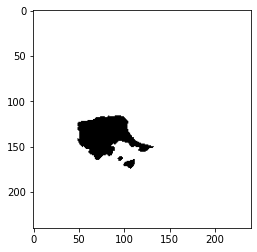

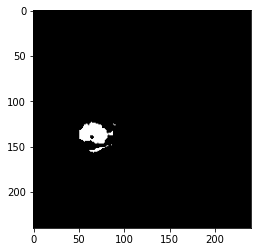

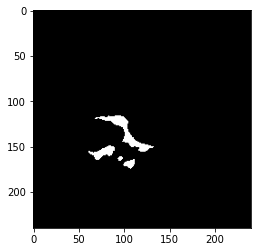

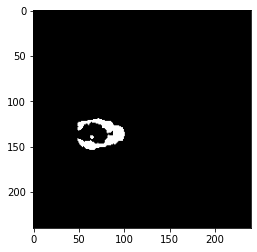

In [10]:
x = np.array(nib.load(list_ts[1]).get_fdata()).astype(np.uint8)
a = to_categorical(x, 5) # 0,1
b = a[:,:,:,0:3]
c = a[:,:,:,4:]
d = np.concatenate((b,c), axis=3)
d.shape


plt.imshow(d[:,:,70,0], cmap='gray')
plt.show()
plt.imshow(d[:,:,70,1], cmap='gray')
plt.show()
plt.imshow(d[:,:,70,2], cmap='gray')
plt.show()
plt.imshow(d[:,:,70,3], cmap='gray')
plt.show()
# plt.imshow(d[:,:,70,4], cmap='gray')
# plt.show()

In [11]:
for n in tqdm(range(len(list_ts[20:60]))):
  x = np.array(nib.load(list_ts[n]).get_fdata()).astype(np.uint8)
  a = to_categorical(x,5)
  b = a[:,:,:,0:3]
  c = a[:,:,:,4:]
  d = np.concatenate((b,c), axis=3)
  e = np.transpose(d, (3,2,0,1))
  e = e[:,70:130,:, :]
  #label_image = np.zeros((4,1600,240,240))
  for i in range(e.shape[1]):
    label_img.append(e[:,i,:,:])

100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


In [12]:
tr_img = np.asarray(Tr_img)
label_img = np.asarray(label_img)
# tr_img = torch.Tensor(Tr_img).to(cuda0)
# ts_img = torch.Tensor(Ts_img).to(cuda0)

print(tr_img.shape, label_img.shape)

(2400, 240, 240) (2400, 4, 240, 240)


In [13]:
from ipywidgets import interact, interactive, IntSlider,ToggleButtons


def explore_img(layer):
  plt.figure(figsize=(10,5))
  plt.imshow(tr_img[layer,:,:], cmap='gray')
  plt.axis('off')
  return layer

interact(explore_img, layer=(0, tr_img.shape[0]-1))

def explore_label(layer):
  plt.figure(figsize=(10,5))
  plt.imshow(label_img[layer,0,:,:], cmap='gray')
  plt.axis('off')
  return layer

interact(explore_label, layer=(0, label_img.shape[0]-1))

interactive(children=(IntSlider(value=1199, description='layer', max=2399), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=1199, description='layer', max=2399), Output()), _dom_classes=('widget-i…

<function __main__.explore_label>

In [14]:
print(tr_img.shape)
tr_img = tr_img.reshape(-1, 1,240,240)
print(tr_img.shape)
#print(label_img.shape)
#label_img = label_img.reshape(-1, 1,240,240)
label_img.shape

(2400, 240, 240)
(2400, 1, 240, 240)


(2400, 4, 240, 240)

In [15]:
tr_img = torch.from_numpy(tr_img).to(cuda0)
label_img = torch.from_numpy(label_img).to(cuda0)

In [16]:
# mx = np.max(tr_img)
# mn = np.min(tr_img)

# mx_y = np.max(label_img)
# mn_y = np.min(label_img)

mx = torch.max(tr_img).to(cuda0)
mn = torch.min(tr_img).to(cuda0)

mx_y = torch.max(label_img).to(cuda0)
mn_y = torch.min(label_img).to(cuda0)

In [17]:
tr_img = torch.true_divide((tr_img - mn),(mx - mn)).to(cuda0)
#tr_img = ((tr_img - mn)/(mx - mn))

#ts_img = torch.Tensor((ts_img - mn_y) /(mx_y - mn_y)).to(cuda0)
label_img = torch.true_divide((label_img - mn_y),(mx_y - mn_y)).to(cuda0)

In [18]:
train_X,valid_X,train_ground,valid_ground = train_test_split(tr_img, label_img, test_size=0.2, random_state=13)

In [19]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, train_X, train_ground):
        self.x = train_X
        self.y = train_ground
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
#x_train_tensor = (train_X).float().to(cuda0)
#y_train_tensor = (train_ground).long().to(cuda0)

train_data = CustomDataset(train_X.float(), train_ground.long())
#print(train_data[0])

#train_data = TensorDataset(x_train_tensor, y_train_tensor)
#print(train_data[0])


In [23]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

In [24]:
dataiter = iter(trainloader)
image, label= dataiter.next()
print(image.shape)
print(label.shape)

torch.Size([1, 1, 240, 240])
torch.Size([1, 4, 240, 240])


<class 'torch.Tensor'>


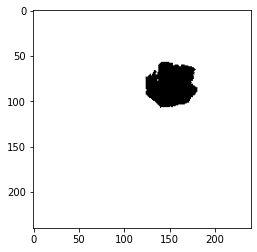

In [25]:
img0 = torch.Tensor.cpu(label)
print(type(img0))
img = img0[0,0,:,:].detach().numpy()
plt.imshow(img, cmap='gray')
plt.show()

In [26]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, valid_X, valid_ground):
        self.x = valid_X
        self.y = valid_ground
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
# x_valid_tensor = (valid_X).float().to(cuda0)
# y_valid_tensor = (valid_ground).long().to(cuda0)

#valid_data = CustomDataset(valid_X, valid_ground)
valid_data = CustomDataset(valid_X.float(), valid_ground.long())
#print(train_data[0])

# valid_data = TensorDataset(x_valid_tensor, y_valid_tensor)
#print(train_data[0])


In [27]:
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1, shuffle=False)

In [28]:
print("Dataset (tr_img) shape: {shape}".format(shape=tr_img.shape))

Dataset (tr_img) shape: torch.Size([2400, 1, 240, 240])


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):

  def contracting_block1(self, in_channels, out_channels, kernel_size =3):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
    return block


  def concat(self, upconv, prev_conv, crop =False):
    if crop:
        c = (prev_conv.size()[2] - upconv.size()[2]) // 2
        prev_conv = F.pad(prev_conv, (-c, -c, -c, -c))
    return torch.cat((upconv, prev_conv), 1)


  def expansive_block(self, in_channels, out_channels, mid_channels, kernel_size=3):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=mid_channels, kernel_size =3, padding= 1, stride=2, output_padding=1),
    )
    return block

  def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1, stride=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel,padding=1, stride=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
        torch.nn.Sigmoid(),
        #torch.nn.BatchNorm2d(out_channels),
    )
    return  block
   

  def __init__(self, in_channel, out_channel):
    super(UNet, self).__init__()
    #Encode
    self.conv_block1 = self.contracting_block1(in_channels =in_channel, out_channels=64)
    self.pool_block1 = nn.MaxPool2d(kernel_size=2)
    self.conv_block2 = self.contracting_block1(64, 128)
    self.pool_block2 = nn.MaxPool2d(kernel_size=2)
    self.conv_block3 = self.contracting_block1(128,256)
    self.pool_block3 = nn.MaxPool2d(kernel_size=2)
    self.conv_block4 = self.contracting_block1(256,512)
    self.pool_block4 = nn.MaxPool2d(kernel_size=2)
    self.centre_block = nn.Sequential(
        nn.Conv2d(512,1024,3,padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(1024),
        nn.Conv2d(1024, 1024, 3,padding=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(1024),
        nn.ConvTranspose2d(in_channels= 1024, out_channels = 512, kernel_size = 3, padding =1, stride=2, output_padding=1),
    )
    self.convup_block1 = self.expansive_block(1024, 512, 256)
    self.convup_block2 = self.expansive_block(512, 256, 128)
    self.convup_block3 = self.expansive_block(256, 128, 64)
    self.final_layer = self.final_block(128, 64, out_channel)
  

  def forward(self,x):
    encode_block1 = self.conv_block1(x)
    encode_pool1 = self.pool_block1(encode_block1)
    encode_block2 = self.conv_block2(encode_pool1)
    encode_pool2 = self.pool_block2(encode_block2)
    encode_block3 = self.conv_block3(encode_pool2)
    encode_pool3 = self.pool_block3(encode_block3)
    encode_block4 = self.conv_block4(encode_pool3)
    encode_pool4 = self.pool_block4(encode_block4)

    centre_block1 = self.centre_block(encode_pool4)

    decode_block0 = self.concat(centre_block1, encode_block4, crop =True)
    concat_block0 = self.convup_block1(decode_block0)
    decode_block1 = self.concat(concat_block0, encode_block3, crop=True)
    concat_block1 = self.convup_block2(decode_block1)
    decode_block2 = self.concat(concat_block1, encode_block2, crop=True)
    concat_block3 = self.convup_block3(decode_block2)
    decode_block3 = self.concat(concat_block3, encode_block1, crop=True)
    final_layer1 = self.final_layer(decode_block3)
    return(final_layer1)

In [30]:
def soft_dice_loss(y_true, y_pred, axis=1,epsilon=0.00001):
    dice_numerator = torch.sum(y_true * y_pred, axis )
    dice_denominator = torch.sum(y_true**2, axis) + torch.sum(y_pred**2, axis)
    dice_coefficient = torch.mean(torch.true_divide(2*dice_numerator+epsilon,dice_denominator+epsilon))
    dice_loss = 1 - dice_coefficient
    return dice_loss

In [31]:
model = UNet(1,4).to(cuda0)

In [33]:
out = model(image)
out.shape

torch.Size([1, 4, 240, 240])

In [ ]:
x = torch.zeros((1,4,240,240))
print(out.shape, x.shape)
for i in range(out.shape[0]):
  for j in range(out.shape[1]):
    for k in range(out.shape[2]):
      for l in range(out.shape[3]):  
        if y[i,j,k,l] >= 0.25:
          x[i,j,k,l] = y[i,j,k,l]
        else:
          x[i,j,k,l] =0

In [ ]:
_,pred =torch.max(out.data, 1)
print(pred[0,:,100])
_,p = torch.max(labels.data,1)
p[0,:,100]

In [ ]:
print(labels.shape)
_,labels = torch.max(labels.data,1)
print(labels.shape)
_,pred= torch.max(out.data,1)
print(pred.shape)
#pred = pred[0,:,:]
# print(pred[:,80],a[:,90])
ans = soft_dice_loss(labels, pred)
ans

torch.Size([1, 4, 240, 240])
torch.Size([1, 240, 240])
torch.Size([1, 240, 240])


tensor(0.9050, device='cuda:0')

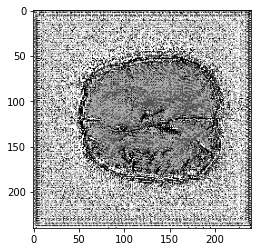

In [ ]:
ans = torch.Tensor.cpu(pred)
img = ans[0,:,:].detach().numpy()
plt.imshow(img, cmap='gray')
plt.show()

In [37]:
def evaluation(dataloader, model):
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(cuda0), labels.to(cuda0)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        _,labels = torch.max(labels.data,1)
        # y_pred = pred[0,:,:]
        # labels = labels[0,:,:,:]
        dice = soft_dice_loss(labels, pred)
    return dice

In [38]:
import torch.optim as optim

#opt = optim.SGD(model.parameters(), lr= 0.001, momentum =0.9)
opt =torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#loss_fn = soft_dice_loss(outputs, labels)

In [ ]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 30
train_loss =[]
valid_loss = []
for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(cuda0), labels.to(cuda0)
        
        opt.zero_grad()

        outputs = model(inputs)
        # _,labels = torch.max(labels.data, 1)
        # _,pred = torch.max(outputs.data, 1)
        loss = soft_dice_loss(labels, outputs)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, valid Dloss: %0.2f, Train DLoss: %0.2f' % (epoch, max_epochs, evaluation(validloader, model), evaluation(trainloader, model)))
    train_loss.append(evaluation(trainloader, model))
    valid_loss.append(evaluation(validloader, model))
    
plt.plot(loss_epoch_arr)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()

Epoch: 0/30, valid Dloss: 0.45, Train DLoss: 0.31
Epoch: 1/30, valid Dloss: 0.38, Train DLoss: 0.20
Epoch: 2/30, valid Dloss: 0.36, Train DLoss: 0.19
Epoch: 3/30, valid Dloss: 0.43, Train DLoss: 0.00
Epoch: 4/30, valid Dloss: 0.35, Train DLoss: 0.22
Epoch: 5/30, valid Dloss: 0.30, Train DLoss: 0.19
Epoch: 6/30, valid Dloss: 0.16, Train DLoss: 0.11
Epoch: 7/30, valid Dloss: 0.13, Train DLoss: 0.15
Epoch: 9/30, valid Dloss: 0.13, Train DLoss: 0.05
Epoch: 10/30, valid Dloss: 0.11, Train DLoss: 0.11
Epoch: 11/30, valid Dloss: 0.07, Train DLoss: 0.12


In [ ]:
import torch.optim as optim
#out_channel represents number of segments desired
unet = UNet(in_channel=1,out_channel=1).to(cuda0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(images)
print(outputs.shape)
# permute such that number of desired segments would be on 4th dimension
out = outputs.permute(0, 2, 3, 1)
m = outputs.shape[0]
print(m)
# Resizing the outputs and label to caculate pixel wise softmax loss
p = out.resize(m*240*240, 2)
print(p.shape)
q = labels.resize(m*240*240)
loss = criterion(p, q)
loss.backward()
optimizer.step()
print(loss)

In [ ]:
label = torch.Tensor.cpu(q)
label = np.ravel(label)

In [ ]:
p = torch.Tensor.cpu(p)
correct = (p== label)
print(correct)

In [ ]:
_,pred = torch.max(p.data,1)
print(_,pred)

In [ ]:
import collections
print(collections.Counter(label))
pred = torch.Tensor.cpu(pred)
pred = np.asarray(pred)
print(type(pred))
print(collections.Counter(pred))

In [ ]:
TP = np.sum((label == 1) & (pred == 1))
FP = np.sum((label == 0) & (pred ==1))
FN = np.sum((label == 1) & (pred == 0))
#mask_sum = np.sum(np.abs(label))+np.sum(np.abs(pred))

In [ ]:
print(TP)
print(FP)
print(FN)
smooth = 0.001
dice = 2*(TP+ smooth)/(2*TP + FP + FN +smooth)
iou = (TP+ smooth)/(TP + FP + FN +smooth)
print(dice, iou)

In [ ]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(cuda0), labels.to(cuda0)
        outputs = unet(inputs)
        out = outputs.permute(0, 2, 3, 1)
        m = outputs.shape[0]
        p = out.resize(m*240*240, 2)
        #p = torch.Tensor.cpu(p)
        q = labels.resize(m*240*240)
        _,pred = torch.max(p.data,1)
        label = torch.Tensor.cpu(q)
        label = np.ravel(label)
        #correct += (p== label)
        TP = np.sum((label == 1) & (pred == 1))
        FP = np.sum((label == 0) & (pred ==1))
        FN = np.sum((label == 1) & (pred == 0))
        smooth = 0.001
        dice =1 - 2*(TP+ smooth)/(2*TP + FP + FN +smooth)
        #iou = (intr + smooth)/(union + smooth)
    return  dice

In [ ]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [ ]:
if cuda0.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.Size([1, 2, 240, 240])


<function matplotlib.pyplot.show>

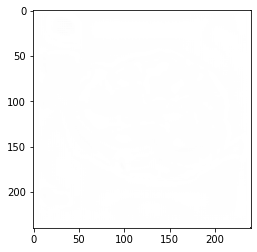

In [ ]:
out = outputs.cpu()
print(out.shape)
out_img = out[0,0,:,:].detach()
out_img.shape
plt.imshow(out_img, cmap='gray')
plt.show